## Food Access Index Exploration
With the preceding jupyter notebook and/or R markdown documents, we have explored wwith different methods to compute an index for food access, including:
* Number of Supermarkets Aggregatd at Each MSOAs
* Number of Supermarket within 1km buffer of MSOA, adjusted for MSOA area
* Percentage of Area of the MSOA falling within a 1km radius of a Supermarket
* Average Suparmarket KDE Estimate among Built-up Area

In this note book, we will complete the following:
* Explore the indicators and identify the cut off point for food desert specification
* Validate the relationship between health and th food access

The following data will be used:
* Social Demographic Data `./data/ons_census_2021.csv`
* Food Access Specifiaction (by shapefile processing) `./data/food_access_spec.csv`
* Food Access Specification (by raster processing) `spmkt_spec_satellite.csv`

For visulisation, we may also need the MSOA boundary `./data/MSOA_2021`.

In [1]:
# data manipulation
import pandas as pd 
import geopandas as gpd 
import numpy as np 

# data viz
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use("ggplot")

# regression
import statsmodels.formula.api as smf

/Users/Tra_FIT/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
<ipython-input-1-ec38423a4f7a>:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS dir

In [2]:
# loading the data
ons = pd.read_csv("./data/ons_census_2021.csv")
fas_shp = pd.read_csv("./data/food_access_spec.csv")
fas_ras = pd.read_csv("./data/spmkt_spec_satellite.csv", index_col = 0)
msoa_shp = gpd.read_file("./data/MSOA_2021")

# filter for only english msoa
msoa_shp = msoa_shp[msoa_shp["MSOA21CD"].str.contains("E")]
 
# among the food specification subset the relevant columns and rename them
fas_shp = fas_shp.drop(columns = ["MSOA21NM", "n_supermarket_buffer"])
fas_shp.columns = ["MSOA21CD","area","urban","n_spmkt","d_spmkt","catchment_pct"]
fas_ras.columns = ["MSOA21CD","fas_kde"]

# merge all the data into one
df = fas_shp.merge(fas_ras, on = "MSOA21CD", how = 'outer')\
        .merge(ons, on = "MSOA21CD", how = 'outer')

# return gdf 
gdf = msoa_shp.merge(df, on = "MSOA21CD", how = "left")

In [3]:
df.describe(include = "all")

,MSOA21CD,area,urban,n_spmkt,d_spmkt,catchment_pct,fas_kde,rm008,pop,pop_communal_establishment,...,h_fair,h_bad,h_vbad,imd_0,imd_1,imd_2,imd_3,imd_4,RUC11CD,RUC11
count,6856,6.856000e+03,6856,6856.000000,6856.000000,6856.000000,6.717000e+03,6856.000000,6856.000000,6856.000000,...,6856.000000,6856.000000,6856.000000,6856.0,6856.000000,6856.000000,6856.000000,6856.000000,6856,6856
unique,6856,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,8
top,E02002898,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1,Urban city and town
freq,1,NaN,5658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2966,2966
mean,NaN,1.902896e+07,NaN,1.225058,3.608956,0.655240,1.200794e-06,0.232114,8095.735123,143.786902,...,0.179686,0.052054,0.011843,1.0,0.516530,0.181399,0.039377,0.002327,NaN,NaN
std,NaN,4.781704e+07,NaN,1.416879,6.323857,0.322534,1.912018e-06,0.146061,1773.814689,444.991175,...,0.041740,0.018208,0.004734,0.0,0.088988,0.069755,0.024868,0.002208,NaN,NaN
min,NaN,2.944143e+05,NaN,0.000000,0.000000,0.000000,1.092951e-09,0.030103,2028.000000,0.000000,...,0.063946,0.010423,0.001516,1.0,0.270893,0.038512,0.003144,0.000000,NaN,NaN
25%,NaN,1.666862e+06,NaN,0.000000,0.302229,0.385274,1.929682e-07,0.119286,6750.750000,17.000000,...,0.149376,0.038724,0.008435,1.0,0.449458,0.126133,0.019601,0.000750,NaN,NaN
50%,NaN,2.990747e+06,NaN,1.000000,1.487510,0.731977,5.861599e-07,0.195650,7853.000000,55.000000,...,0.176569,0.048904,0.011015,1.0,0.508603,0.168967,0.032659,0.001657,NaN,NaN
75%,NaN,1.033509e+07,NaN,2.000000,3.864478,0.978415,1.323793e-06,0.305863,9161.250000,112.000000,...,0.207213,0.062610,0.014361,1.0,0.579878,0.226816,0.053940,0.003255,NaN,NaN


In [4]:
gdf.describe(include = 'all')

,MSOA21CD,MSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,area,urban,...,h_fair,h_bad,h_vbad,imd_0,imd_1,imd_2,imd_3,imd_4,RUC11CD,RUC11
count,6856,6856,6856.000000,6856.000000,6856.000000,6856.000000,6856,6856,6.856000e+03,6856,...,6856.000000,6856.000000,6856.000000,6856.0,6856.000000,6856.000000,6856.000000,6856.000000,6856,6856
unique,6856,6856,NaN,NaN,NaN,NaN,6856,6856,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,8
top,E02000001,City of London 001,NaN,NaN,NaN,NaN,283e7adc-faef-4736-9a0b-146cb27c72ec,POLYGON ((532153.7029999997 182165.15499999933...,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1,Urban city and town
freq,1,1,NaN,NaN,NaN,NaN,1,1,NaN,5658,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2966,2966
mean,NaN,NaN,453969.743145,275745.554551,-1.216356,52.370738,NaN,NaN,1.902896e+07,NaN,...,0.179686,0.052054,0.011843,1.0,0.516530,0.181399,0.039377,0.002327,NaN,NaN
std,NaN,NaN,84059.420657,127007.741405,1.216644,1.146381,NaN,NaN,4.781704e+07,NaN,...,0.041740,0.018208,0.004734,0.0,0.088988,0.069755,0.024868,0.002208,NaN,NaN
min,NaN,NaN,91327.000000,11447.000000,-6.302170,49.923300,NaN,NaN,2.944143e+05,NaN,...,0.063946,0.010423,0.001516,1.0,0.270893,0.038512,0.003144,0.000000,NaN,NaN
25%,NaN,NaN,393522.250000,175117.250000,-2.098055,51.463100,NaN,NaN,1.666862e+06,NaN,...,0.149376,0.038724,0.008435,1.0,0.449458,0.126133,0.019601,0.000750,NaN,NaN
50%,NaN,NaN,448350.000000,259002.500000,-1.285650,52.215550,NaN,NaN,2.990747e+06,NaN,...,0.176569,0.048904,0.011015,1.0,0.508603,0.168967,0.032659,0.001657,NaN,NaN
75%,NaN,NaN,524110.500000,389067.500000,-0.208935,53.395700,NaN,NaN,1.033509e+07,NaN,...,0.207213,0.062610,0.014361,1.0,0.579878,0.226816,0.053940,0.003255,NaN,NaN


In [5]:
# map urban to rural column
gdf["rural"] = gdf["urban"].map({True:False, False: True})

## 1. Standardize Food Access Index

In [3]:
gdf.head()

,MSOA21CD,MSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,area,urban,...,h_fair,h_bad,h_vbad,imd_0,imd_1,imd_2,imd_3,imd_4,RUC11CD,RUC11
0,E02000001,City of London 001,532384,181355,-0.093490,51.5156,283e7adc-faef-4736-9a0b-146cb27c72ec,"POLYGON ((532153.703 182165.155, 532158.250 18...",2.885422e+06,True,...,0.107189,0.027147,0.005476,1.0,0.402320,0.087505,0.016891,0.001628,A1,Urban major conurbation
1,E02000002,Barking and Dagenham 001,548267,189685,0.138756,51.5865,7b32290e-3b18-45b1-b5d5-bf778f71e3ce,"POLYGON ((548881.304 190819.980, 548881.125 19...",2.161561e+06,True,...,0.180896,0.060017,0.016785,1.0,0.667596,0.289547,0.075958,0.008362,A1,Urban major conurbation
2,E02000003,Barking and Dagenham 002,548259,188520,0.138149,51.5760,56f43674-2eda-47c0-819a-0cabeb9595f5,"POLYGON ((548958.555 189072.176, 548954.517 18...",2.141515e+06,True,...,0.148588,0.040981,0.009097,1.0,0.580407,0.207125,0.037405,0.000509,A1,Urban major conurbation
3,E02000004,Barking and Dagenham 003,551004,186412,0.176828,51.5564,fbedb5c5-b92a-475f-899e-1baf1dbae111,"POLYGON ((551550.056 187364.705, 551528.633 18...",2.492946e+06,True,...,0.172715,0.047583,0.008131,1.0,0.560849,0.201819,0.043742,0.001299,A1,Urban major conurbation
4,E02000005,Barking and Dagenham 004,548733,186824,0.144267,51.5607,f04829fe-a903-4bca-a88a-ace39fdbd3ac,"POLYGON ((549237.051 187627.941, 549241.319 18...",1.187954e+06,True,...,0.150966,0.044035,0.012182,1.0,0.574656,0.229752,0.058953,0.003581,A1,Urban major conurbation


In [4]:
gdf.columns

Index(['MSOA21CD', 'MSOA21NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'GlobalID',
       'geometry', 'area', 'urban', 'n_spmkt', 'd_spmkt', 'catchment_pct',
       'fas_kde', 'rm008', 'pop', 'pop_communal_establishment', 'h_vgood',
       'h_good', 'h_fair', 'h_bad', 'h_vbad', 'imd_0', 'imd_1', 'imd_2',
       'imd_3', 'imd_4', 'RUC11CD', 'RUC11'],
      dtype='object')

In [5]:
for col in ["n_spmkt", "d_spmkt","catchment_pct", "fas_kde"]:
    mean = gdf[col].mean()
    std = gdf[col].std()
    gdf[col] = (gdf[col] - mean) / std

In [6]:
gdf[["n_spmkt", "d_spmkt","catchment_pct", "fas_kde"]].describe()

,n_spmkt,d_spmkt,catchment_pct,fas_kde
count,6.856000e+03,6.856000e+03,6.856000e+03,6.717000e+03
mean,1.658209e-17,-6.632838e-17,9.949257e-17,5.077572e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.646173e-01,-5.706891e-01,-2.031536e+00,-6.274525e-01
25%,-8.646173e-01,-5.228973e-01,-8.370150e-01,-5.271003e-01
50%,-1.588409e-01,-3.354671e-01,2.379197e-01,-3.214581e-01
75%,5.469355e-01,4.040596e-02,1.001987e+00,6.432991e-02
max,7.604700e+00,1.160233e+01,1.068910e+00,1.365398e+01


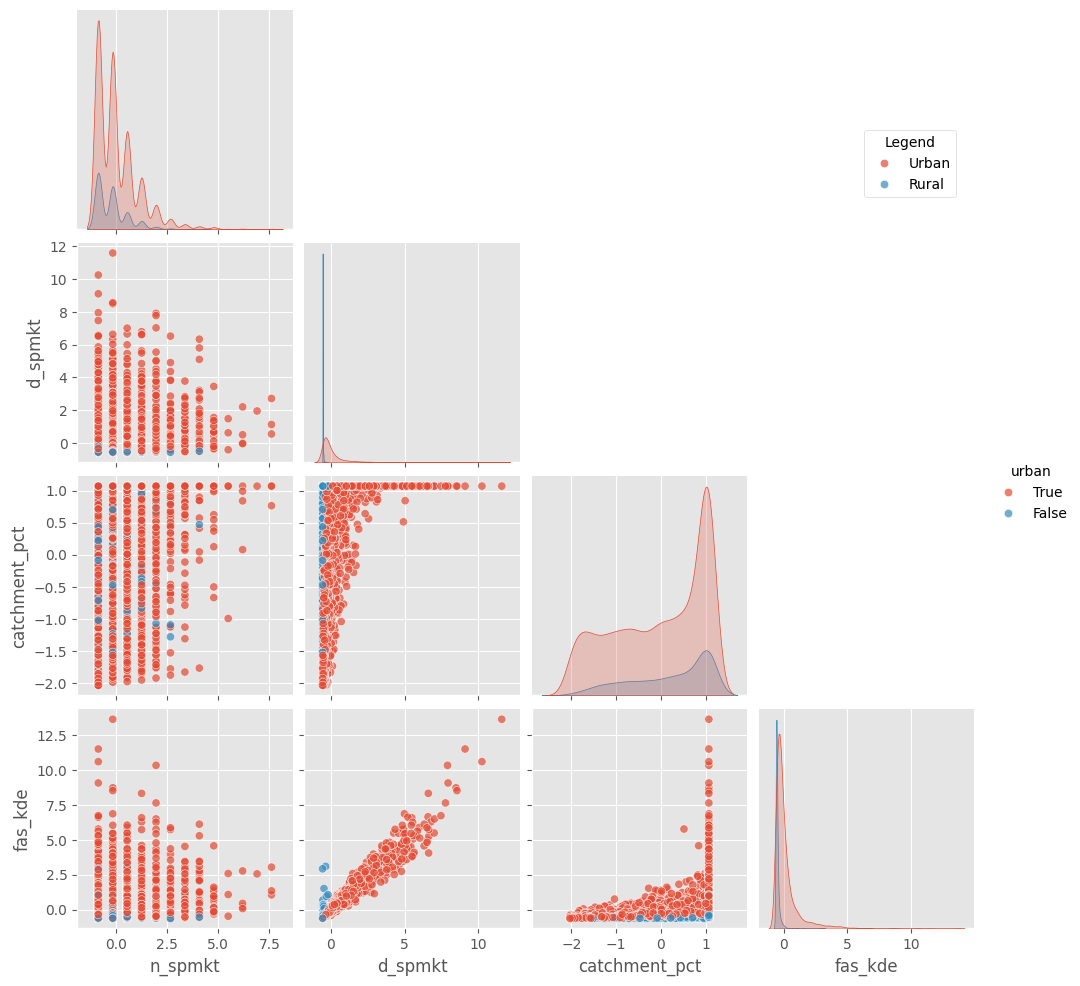

In [31]:
figure = sns.pairplot(data = gdf[["n_spmkt", "d_spmkt","catchment_pct", "fas_kde", "urban"]], 
             hue = "urban", hue_order = [True, False], corner = True,
             plot_kws = {"alpha": 0.7})

handles = figure._legend_data.values()
labels = figure._legend_data.keys()
figure.fig.legend(handles=handles, labels=["Urban", "Rural"],
                   loc=(0.8,0.8), ncol=1, facecolor = "#FFFFFF", frameon = True,
                   title = "Legend")

plt.savefig("./img/fas_scatter.png", dpi = 300)
plt.show()

## 2. Data Analysis (by variable)

/Users/Tra_FIT/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/Tra_FIT/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


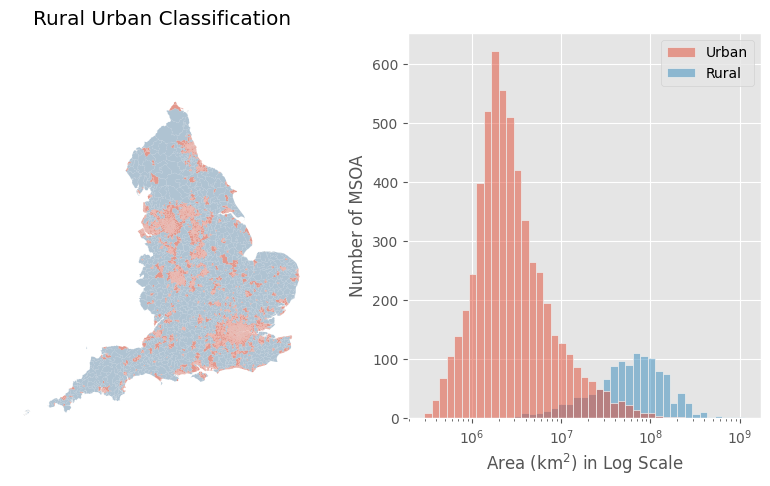

In [20]:
# ad hoc summary
# manipulate to order the legend
temp = gdf.copy(deep=True)
temp["urban"] = temp["urban"].map({True:False,False:True})

fig, ax = plt.subplots(figsize = (10,5), ncols = 2)

# create map plot

gdf[gdf["urban"].fillna(False)].plot(column = "urban",color = "#E3978B", legend = True,
          label = "Urban",
          ax = ax[0])
gdf[~gdf["urban"].fillna(True)].plot(column = "urban",color = "#8EAAC0", legend = True,
          label = "Rural",alpha = 0.7,missing_kwds = {'color' : "#CDCDCD", 'label': "N/A"},
          ax = ax[0])
gdf.boundary.plot(ax = ax[0], linewidth = 0.01,color = "#EFEFEF")
ax[0].set_ylim(0,800000)
ax[0].set_title("Rural Urban Classification")
ax[0].axis("off")


# create histogram
sns.histplot(data = temp.sort_values("urban", ascending = False), 
             x = "area",hue = "urban", log_scale= True, ax = ax[1])

leg = ax[1].get_legend()
leg.set_title("")
labels = ["Urban","Rural"]
for id, text in enumerate(leg.get_texts()):
    # reset the label
    text.set_text(labels[id])
ax[1].set_xlabel("Area (km$^2$) in Log Scale")
ax[1].set_ylabel("Number of MSOA")
plt.savefig("./img/msoa_area.png",dpi = 300)
plt.show()


In [29]:
temp  = df.groupby("urban").agg({"area":"mean"})
area_fact = temp.iloc[0,0] /temp.iloc[1,0]
print(f"The mean area of rural MSOA is {area_fact} times greater than urban MSOA. \nThe square root of the factor is {np.sqrt(area_fact)}")

The mean area of rural MSOA is 15.565698291042139 times greater than urban MSOA. 
The square root of the factor is 3.945338805608732


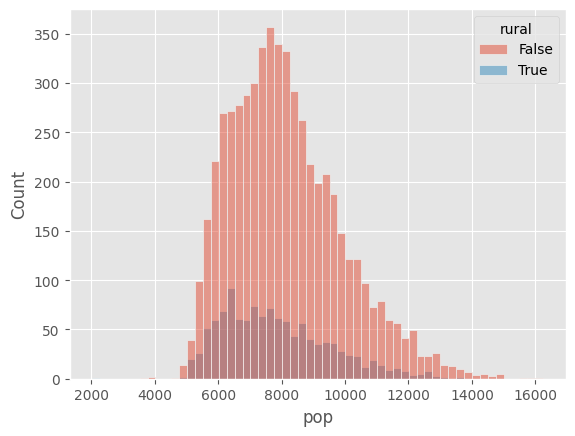

In [30]:
# create the plot
sns.histplot(data = gdf, x = "pop",hue = "rural")
plt.show()

### 2.1 Food Desert Specifiaction Map

/Users/Tra_FIT/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/Tra_FIT/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 5
  Warn("Warning: setting k to %d" % k_q, UserWarning)


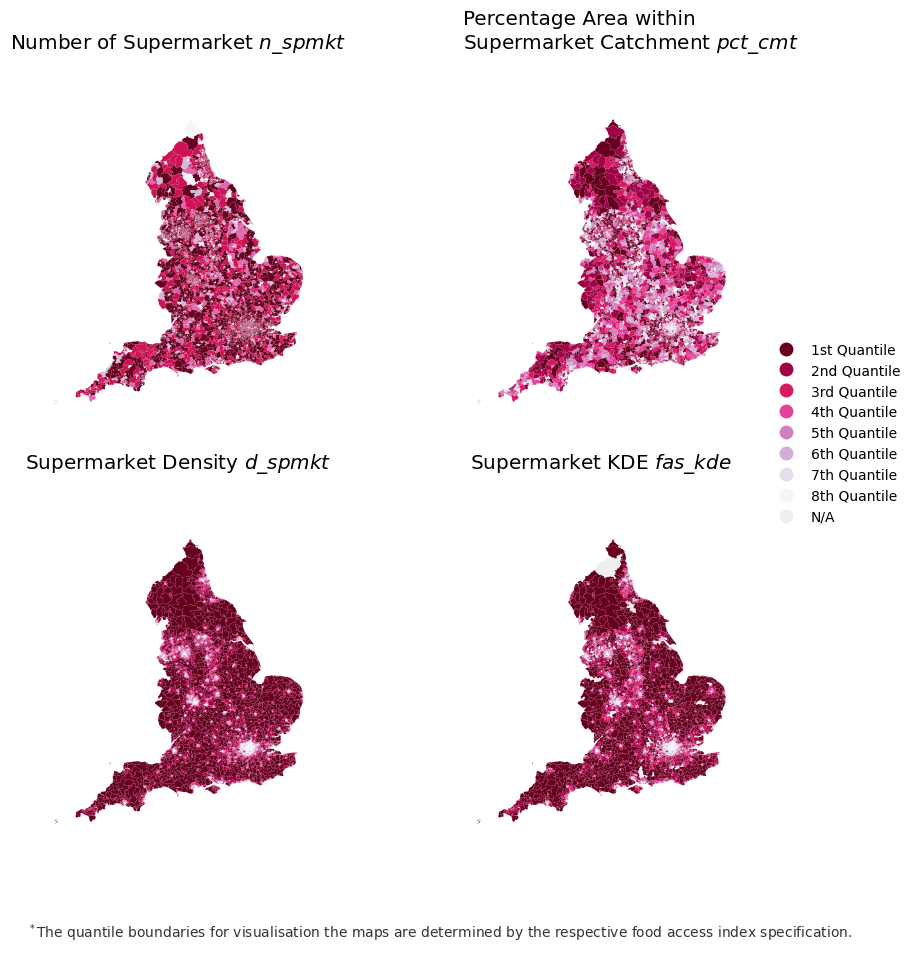

In [21]:
fig, ax = plt.subplots(ncols= 2, nrows = 2, figsize = (10,10))
cmap = "PuRd_r"
quantiles = 8

# number of supermarket ------------------------------
gdf.plot(column = "n_spmkt",scheme = "quantiles",cmap = cmap, k = quantiles,
          missing_kwds = {'color' : "#EFEFEF", 'label': 0},
        #   legend = True,
        #   legend_kwds = {'loc':(0.1,0.85), 'ncol':3,"facecolor":"#FFFFFF", "frameon":False},
          ax = ax[0,0])
ax[0,0].set_ylim(0,800000)
ax[0,0].set_title("Number of Supermarket $n\_spmkt$")
ax[0,0].axis("off")

# supermarket density -----------------
gdf.plot(column = "d_spmkt",scheme = "quantiles",cmap = cmap, k = quantiles,
          missing_kwds = {'color' : "#EFEFEF", 'label': 0},
        #   legend = True,
        #   legend_kwds = {'loc':(0.1,0.85), 'ncol':3,"facecolor":"#FFFFFF", "frameon":False},
          ax = ax[1,0])
ax[1,0].set_ylim(0,800000)
ax[1,0].set_title("Supermarket Density $d\_spmkt$")
ax[1,0].axis("off")

# percentage in catchment -------------------------------------
gdf.plot(column = "catchment_pct", scheme = "quantiles",cmap = cmap, k = quantiles,
          missing_kwds = {'color' : "#EFEFEF", 'label': 0},
        #   legend = True,
        #   legend_kwds = {'loc':(0,0.75), 'ncol':2,"facecolor":"#FFFFFF", "frameon":False},
          ax=ax[0,1])

ax[0,1].set_ylim(0,800000)
ax[0,1].set_title("Percentage Area within\nSupermarket Catchment $pct\_cmt$", loc = "left")
ax[0,1].set_axis_off()

# leg = ax[0,1].get_legend()
# for text in leg.get_texts():
#     # get the upper and lower bound
#     limits = [float(lim) for lim in  text.get_text().split(",")]
#     # paraw as lavle
#     label = f"{limits[0]:.0%}-{limits[1]:.0%}"
#     text.set_text(label)

# kde estimate --------------------------------------
gdf.plot(column = "fas_kde",scheme = "quantiles",cmap = cmap, k = quantiles,
          missing_kwds = {'color' : "#EFEFEF", 'label': 0},
         legend = True,
          legend_kwds = { 'ncol':1,"facecolor":"#FFFFFF", "frameon":False,
                        'loc':(1.1,0.85),
                        },
          ax = ax[1,1])
ax[1,1].set_ylim(0,800000)
ax[1,1].set_title("Supermarket KDE $fas\_kde$")
ax[1,1].axis("off")

# change the legend label (using the 4th quantile plot)
leg = ax[1,1].get_legend()
labels = ["1st Quantile","2nd Quantile", "3rd Quantile","4th Quantile", 
          "5th Quantile","6th Quantile", "7th Quantile","8th Quantile","N/A"]
for id, text in enumerate(leg.get_texts()):
      # get the upper and lower bound
      limits = [float(lim) for lim in  text.get_text().split(",")]
      # paraw as lavle
      label = labels[id]
      text.set_text(label)

annotation = "$^*$The quantile boundaries for visualisation the maps are determined by the respective food access index specification."
fig.text(0.15,0,annotation,fontsize = 10, color  = "#333333", fontweight = "light")

# show the plot
plt.savefig("./img/fas_composite.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [25]:
gdf[["d_spmkt","fas_kde"]].describe()

,d_spmkt,fas_kde
count,6.856000e+03,6.717000e+03
mean,-6.632838e-17,5.077572e-17
std,1.000000e+00,1.000000e+00
min,-5.706891e-01,-6.274525e-01
25%,-5.228973e-01,-5.271003e-01
50%,-3.354671e-01,-3.214581e-01
75%,4.040596e-02,6.432991e-02
max,1.160233e+01,1.365398e+01


In [26]:
gdf[gdf["MSOA21NM"].str.contains("Tameside")][["MSOA21NM","d_spmkt","fas_kde","urban"]]

,MSOA21NM,d_spmkt,fas_kde,urban
1167,Tameside 001,-0.539655,-0.549343,True
1168,Tameside 002,-0.434228,-0.475542,True
1169,Tameside 003,-0.483951,-0.577138,True
1170,Tameside 004,-0.051027,-0.355715,True
1171,Tameside 005,-0.233850,-0.141031,True
1172,Tameside 006,0.152216,0.006647,True
1173,Tameside 007,-0.024150,-0.019043,True
1174,Tameside 008,-0.230951,-0.306718,True
1175,Tameside 009,-0.549644,-0.609686,True
1176,Tameside 010,-0.362723,-0.435230,True


In [37]:
gdf[["MSOA21NM","fas_kde","urban"]].sort_values("fas_kde").head(50)

,MSOA21NM,fas_kde,urban
3848,Eden 007,-0.627453,False
4001,North Devon 002,-0.627339,False
3822,Carlisle 002,-0.627282,False
3841,Copeland 008,-0.627218,False
4322,Chelmsford 018,-0.627106,True
5535,Harrogate 006,-0.627023,False
5514,Craven 001,-0.626996,False
5336,King's Lynn and West Norfolk 002,-0.626975,False
4983,Burnley 009,-0.626895,True
3997,Mid Devon 009,-0.626852,False


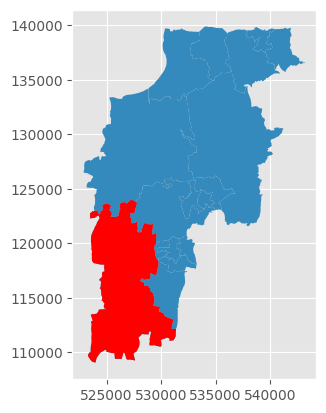

In [36]:
graph = gdf[gdf["MSOA21NM"].str.contains("Mid Sussex")].plot()
gdf[gdf["MSOA21NM"].str.contains("Mid Sussex 016")].plot(color = "red", ax = graph )
plt.show()

## 3. Regrssion Analysis

In [91]:
gdf.columns

Index(['MSOA21CD', 'MSOA21NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'GlobalID',
       'geometry', 'area', 'urban', 'n_spmkt', 'd_spmkt', 'catchment_pct',
       'fas_kde', 'rm008', 'pop', 'pop_communal_establishment', 'h_vgood',
       'h_good', 'h_fair', 'h_bad', 'h_vbad', 'imd_0', 'imd_1', 'imd_2',
       'imd_3', 'imd_4', 'RUC11CD', 'RUC11'],
      dtype='object')

In [40]:
# define formula
formula = "h_bad ~ fas_kde"

# fit and print result
mod = smf.ols(formula=formula, data=gdf)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 h_good   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     199.2
Date:                Wed, 07 Aug 2024   Prob (F-statistic):          1.04e-161
Time:                        15:50:42   Log-Likelihood:                 10533.
No. Observations:                6717   AIC:                        -2.106e+04
Df Residuals:                    6712   BIC:                        -2.102e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5518      0.005    118.092      0.000       0.543       0.561
urban[T.True]            -0.0006      0.004     -0.141      0.888      -0.008       0.007
pop                   -4.031e-06   3.47e-07    -11.603      0.000   -4.71e-06   -3.35e-06
fas_kde                   0.0025      0.007      0.371      0.710      -0.011       0.016
fas_kde:urban[T.True]    -0.0187      0.007     -2.739      0.006      -0.032      -0.005
==============================================================================
Omnibus:                      145.258   Durbin-Watson:                   0.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.506
Skew:                          -0.345   Prob(JB):                     6.28e-35
Kurtosis:                       3.296   Cond. No.                     1.47e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
# add the parameters, the statistical significance,
res_df = pd.DataFrame(res.params.apply(lambda x: f"{x:.4f}") + stat_sig + "(" +res.bse.apply(lambda x : f"{x:.4f}") + ")" )
# add the n obs and the r squared
res_df.loc["n",0] = res.nobs
res_df.loc["R2",0] = res.rsquared
# rename the column
res_df = res_df.rename(columns = {0:"(1)"} )

### 3.1 Relationship with other Social Demographic Data (IMD)

In [116]:
# return the formula
fas = ["n_spmkt", "d_spmkt","catchment_pct", "fas_kde"]

formula = [
        "imd_3 ~ fas + pop + urban + rm008 + fas*urban",
        "imd_3 ~ fas + pop + urban + rm008",
        "imd_3 ~ fas + pop + urban",
        "imd_3 ~ fas + pop",
        "imd_3 ~ fas"
        ]
formula = sorted(formula)
# instanstiate empty list
result = []
for fa in fas:
    for formulae in formula:
        temp = formulae.replace("fas", fa)
        result.append(temp)




In [128]:
# Iterature the formula list to run the regression
# instantiate datafram
res_df = pd.DataFrame()
for id, form in enumerate(result):
    # fit and print result
    mod = smf.ols(formula=form, data=gdf)
    res = mod.fit()
    
    # process the statistical significance 
    stat_sig = pd.cut(res.pvalues, bins = [-0.01, 0.01,0.05,0.1,1], labels= ["***","**","*",""]).astype("str")
    params = res.params.apply(lambda x: f"{x:.4f}")
    sterr = res.bse.apply(lambda x : f"{x:.4f}")

    # add the parameters, the statistical significance,
    series = params + stat_sig + "(" + sterr + ")" 
    temp = pd.DataFrame(series)
    # add the n obs and the r squared
    temp.loc["n",0] = res.nobs
    temp.loc["R2",0] = f"{res.rsquared:.4f}"
    # rename the column
    temp = temp.rename(columns = {0:f"\({id+1}\)"} )
    # add to the df
    res_df = pd.merge(left = res_df, right = temp, left_index = True, right_index = True,
                      how = "outer")


In [130]:
res_df.to_csv("./regression_output/social_var.csv")

### 3.2 Relationship with Health

In [131]:
# return the formula
fas = ["n_spmkt", "d_spmkt","catchment_pct", "fas_kde"]

# define the formula
formula = [
        "h_bad ~ fas ",
        "h_bad ~ fas + rm008 ",
        "h_bad ~ fas + rm008 + pop ",
        "h_bad ~ fas + rm008 + pop + urban  "
            ]
# instanstiate empty list
result = []
for fa in fas:
    for formulae in formula:
        temp = formulae.replace("fas", fa)
        result.append(temp)

In [132]:
# Iterature the formula list to run the regression
# instantiate datafram
res_df = pd.DataFrame()
for id, form in enumerate(result):
    # fit and print result
    mod = smf.ols(formula=form, data=gdf)
    res = mod.fit()
    
    # process the statistical significance 
    stat_sig = pd.cut(res.pvalues, bins = [-0.01, 0.01,0.05,0.1,1], labels= ["***","**","*",""]).astype("str")
    params = res.params.apply(lambda x: f"{x:.4f}")
    sterr = res.bse.apply(lambda x : f"{x:.4f}")

    # add the parameters, the statistical significance,
    series = params + stat_sig + "(" + sterr + ")" 
    temp = pd.DataFrame(series)
    # add the n obs and the r squared
    temp.loc["n",0] = res.nobs
    temp.loc["R2",0] = f"{res.rsquared:.4f}"
    # rename the column
    temp = temp.rename(columns = {0:f"\({id+1}\)"} )
    # add to the df
    res_df = pd.merge(left = res_df, right = temp, left_index = True, right_index = True,
                      how = "outer")


In [141]:
# reorder the rows
res_df = res_df.iloc[[1,5,6,3,2,4,8,7,9],:]


,\(16\)
Intercept,0.0435***(0.0010)
urban[T.True],-0.0011**(0.0005)
fas_kde,-0.0100***(0.0003)
rm008,0.0917***(0.0019)
pop,-0.0000***(0.0000)
n,6717.0
R2,0.2798


In [144]:
res_df = res_df.rename(index = {"urban[T.True]":"urban","catchment_pct":"cmt_pct"})

In [145]:
res_df.to_csv("./regression_output/health_reg.csv")